<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Patient_Risk_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from keras.models import Sequential
from keras.layers import Dense
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load The Dataset
data=pd.read_csv("/content/drive/MyDrive/DSGP/New/preprocessed_new_dataset.csv")

In [ ]:
data.head()

,Gender,Continent,Age_group,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes
0,0,4,0,True,False,False,False,True,False,True,True,False
1,1,0,2,True,False,False,False,True,False,True,True,False
2,1,0,2,False,False,True,False,True,False,True,False,True
3,0,4,1,False,False,True,False,True,False,True,True,False
4,0,0,0,False,False,True,False,True,False,True,True,False


In [ ]:
data.shape

(64653, 12)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64653 entries, 0 to 64652
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Gender                       64653 non-null  int64
 1   Continent                    64653 non-null  int64
 2   Age_group                    64653 non-null  int64
 3   Socioeconomic_Status_High    64653 non-null  bool 
 4   Socioeconomic_Status_Low     64653 non-null  bool 
 5   Socioeconomic_Status_Middle  64653 non-null  bool 
 6   Tobacco_Use_No               64653 non-null  bool 
 7   Tobacco_Use_Yes              64653 non-null  bool 
 8   Alcohol_Use_No               64653 non-null  bool 
 9   Alcohol_Use_Yes              64653 non-null  bool 
 10  HPV_Related_No               64653 non-null  bool 
 11  HPV_Related_Yes              64653 non-null  bool 
dtypes: bool(9), int64(3)
memory usage: 2.0 MB


**Check Mulitocollinearity**

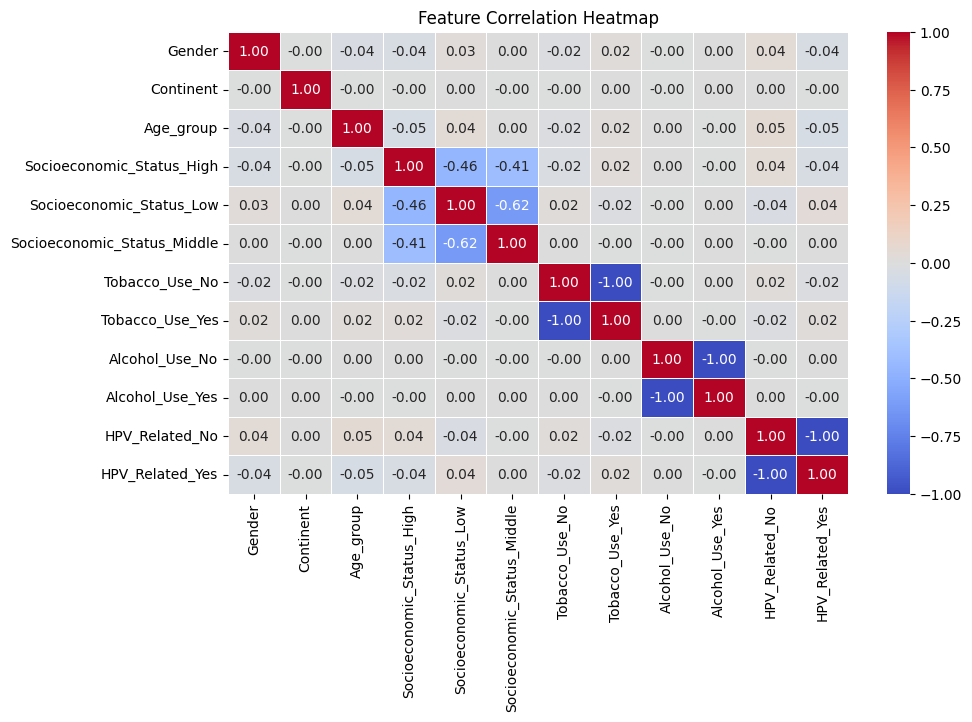

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
#Feature selection for clustering
features = ['Tobacco_Use_Yes','Alcohol_Use_Yes','HPV_Related_Yes','Socioeconomic_Status_Low','Gender']
X = data[features]

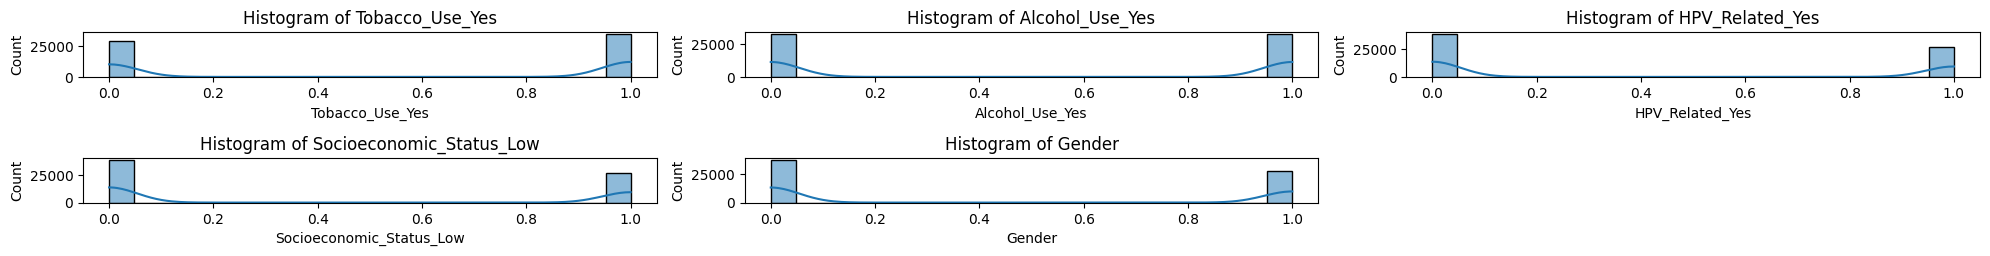

In [ ]:
# Plot histogram for each feature
plt.figure(figsize=(20,6))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

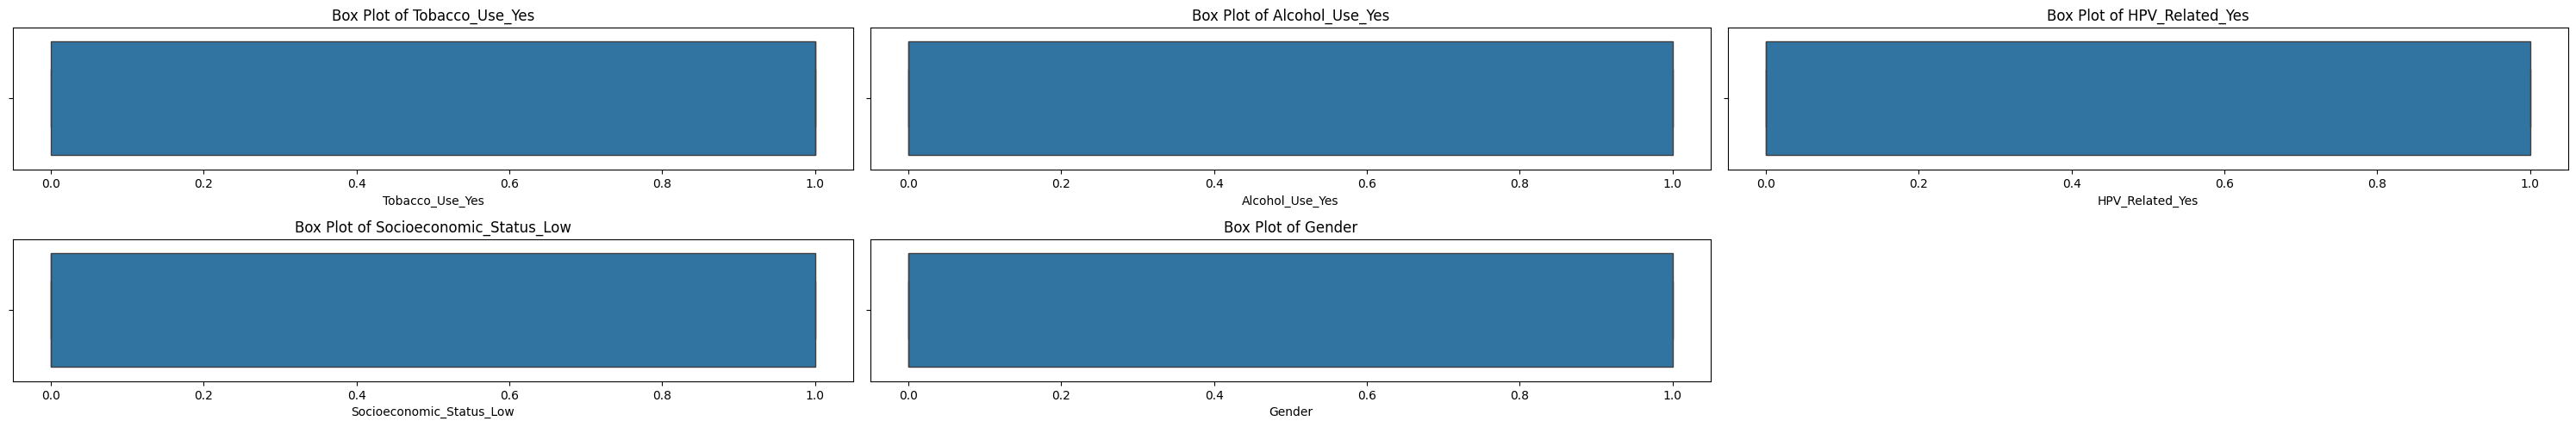

In [ ]:
# Box plot for features
plt.figure(figsize=(30,12))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

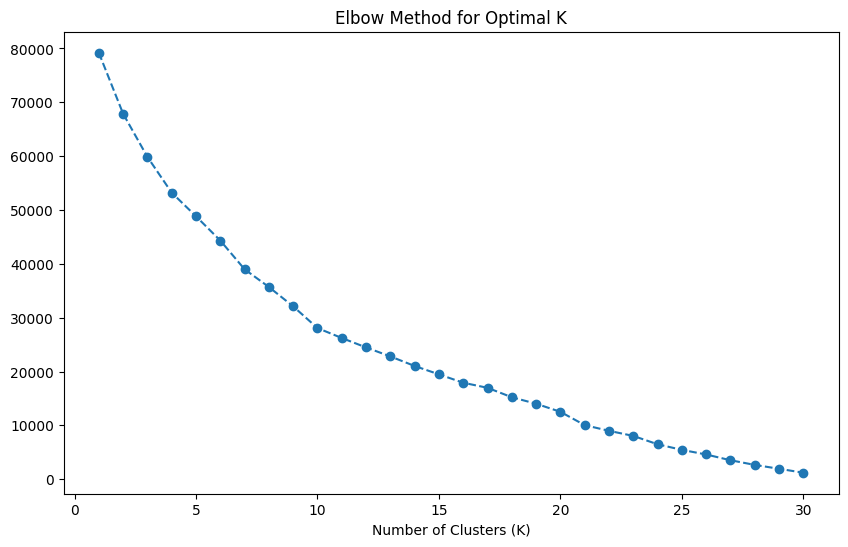

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[features])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define range of K values to test
k_values = [2,3,4,5,7,8,9,10]

# Dictionary to store silhouette scores
silhouette_scores = {}

# Loop through different values of K and compute silhouette scores
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    # Compute silhouette score
    score = silhouette_score(X, cluster_labels)
    silhouette_scores[k] = score
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Find the best K with highest silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nBest K based on silhouette score: {best_k}")

Silhouette Score for K=2: 0.2217
Silhouette Score for K=3: 0.1947
Silhouette Score for K=4: 0.2457
Silhouette Score for K=5: 0.2581
Silhouette Score for K=7: 0.3048
Silhouette Score for K=8: 0.3245
Silhouette Score for K=9: 0.3562
Silhouette Score for K=10: 0.3970

Best K based on silhouette score: 10


In [ ]:
#Applied K-Means clustering with 10 clusters and assigned cluster labels
kmeans = KMeans(n_clusters=10, random_state=42, max_iter=1000)
kmeans.fit_predict(data[features])

data['Cluster'] = kmeans.labels_

In [ ]:
print(data["Cluster"].value_counts())

Cluster
0    9220
1    8374
2    7624
8    6321
4    6083
5    6017
9    5840
7    5307
6    5074
3    4793
Name: count, dtype: int64


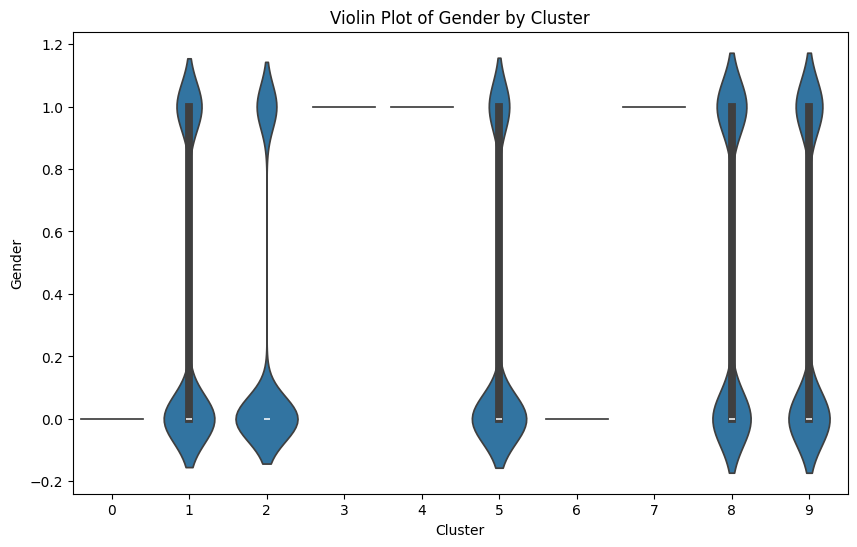

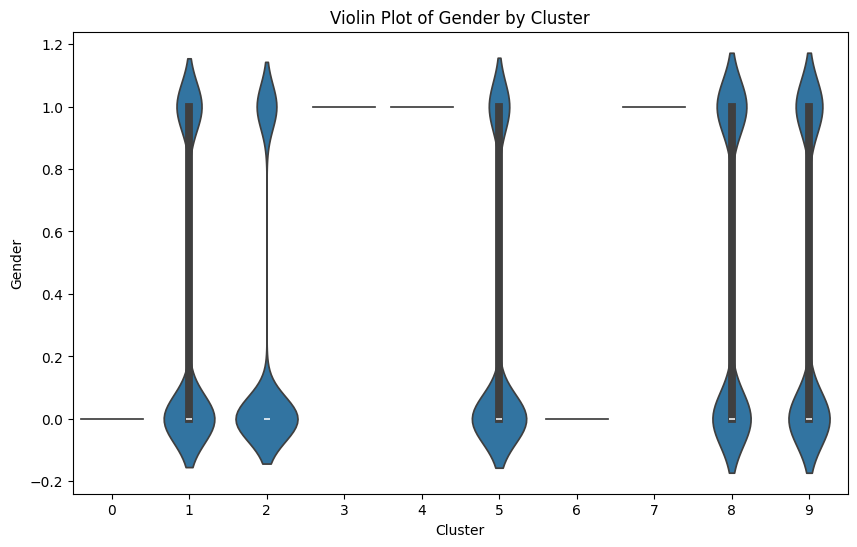

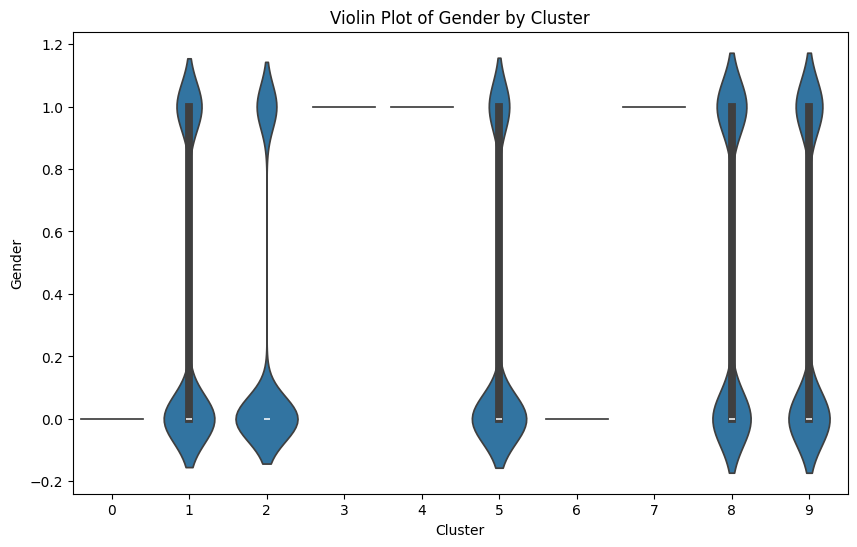

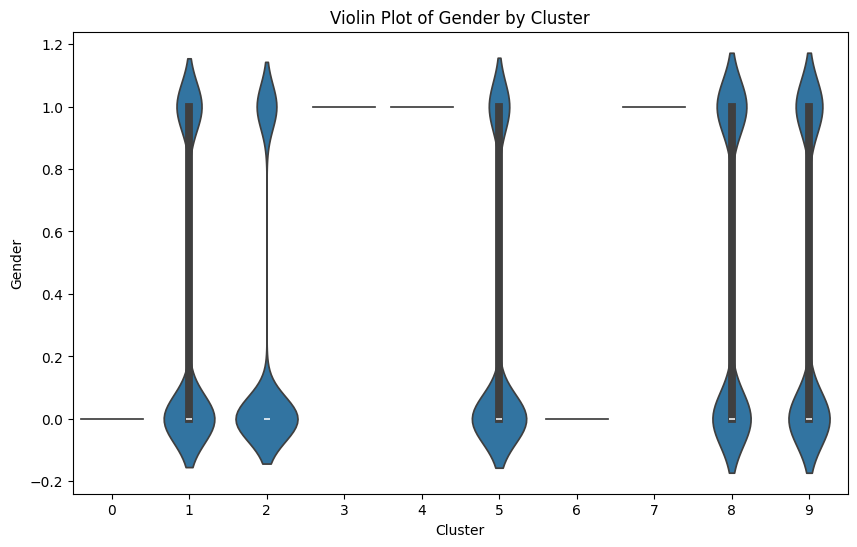

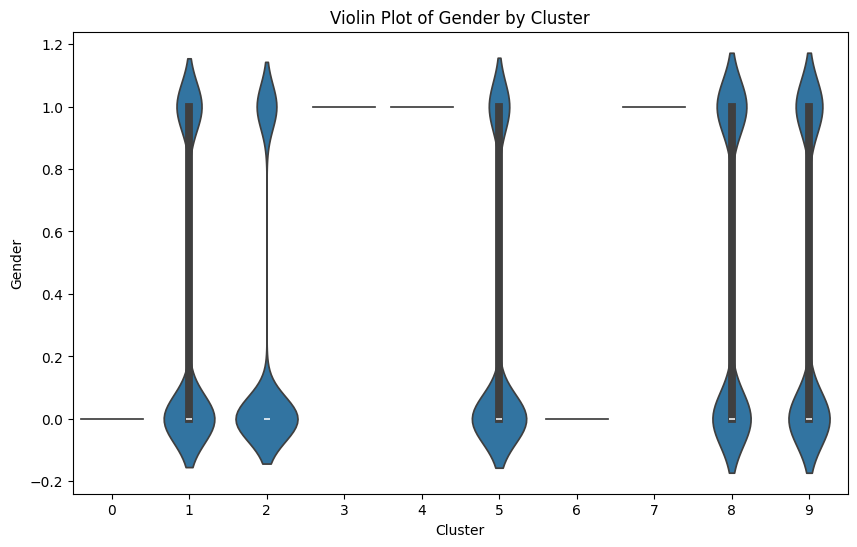

In [ ]:
# Display violin plot
data["Cluster"] = kmeans.labels_

for features in features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Cluster', y=feature, data=data)
    plt.title(f'Violin Plot of {feature} by Cluster')
    plt.xlabel('Cluster')

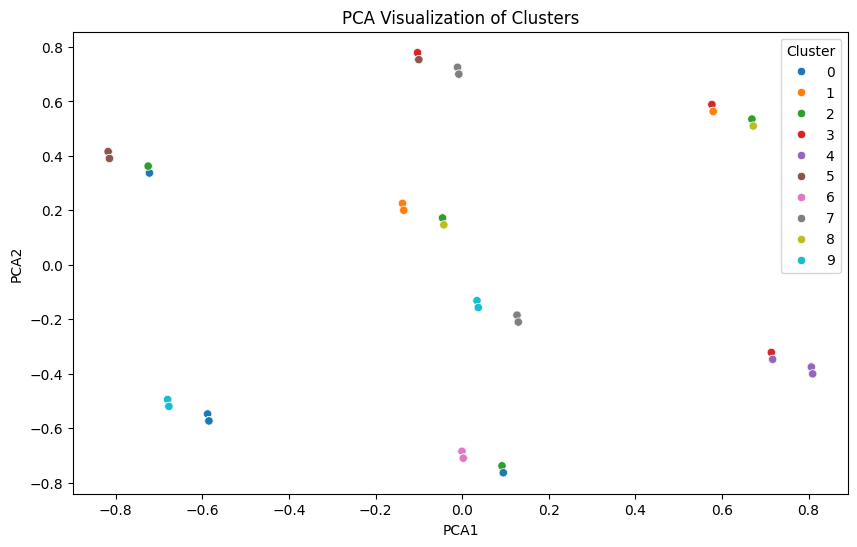

In [ ]:
# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data["PCA1"] = X_pca[:, 0]
data["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=data, palette="tab10")
plt.title('PCA Visualization of Clusters')
plt.show()

Cluster
0    9220
1    8374
2    7624
8    6321
4    6083
5    6017
9    5840
7    5307
6    5074
3    4793
Name: count, dtype: int64


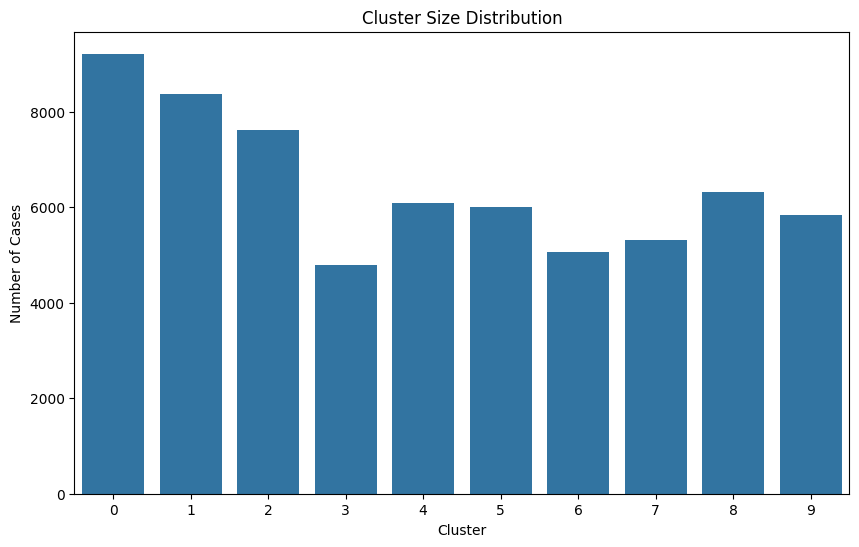

In [ ]:
# Count the number of rows per cluster
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)
# Bar chart of cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Cases')
plt.title('Cluster Size Distribution')
plt.show()

,Tobacco_Use_Yes,Alcohol_Use_Yes,HPV_Related_Yes,Socioeconomic_Status_Low,Gender
Cluster,,,,,
0,0.199665,0.000000,0.224292,0.137113,0.000000
1,0.000000,0.000000,0.000000,0.185081,0.221312
2,0.191271,0.000000,0.177440,0.000000,0.182985
3,0.223393,0.000000,0.199691,0.000000,0.000000
4,0.000000,0.232373,0.000000,0.198155,0.000000
5,0.000000,0.000000,0.000000,0.208620,0.198682
6,0.000000,0.000000,0.000000,0.237025,0.000000
7,0.245013,0.000000,0.000000,0.246862,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.246104


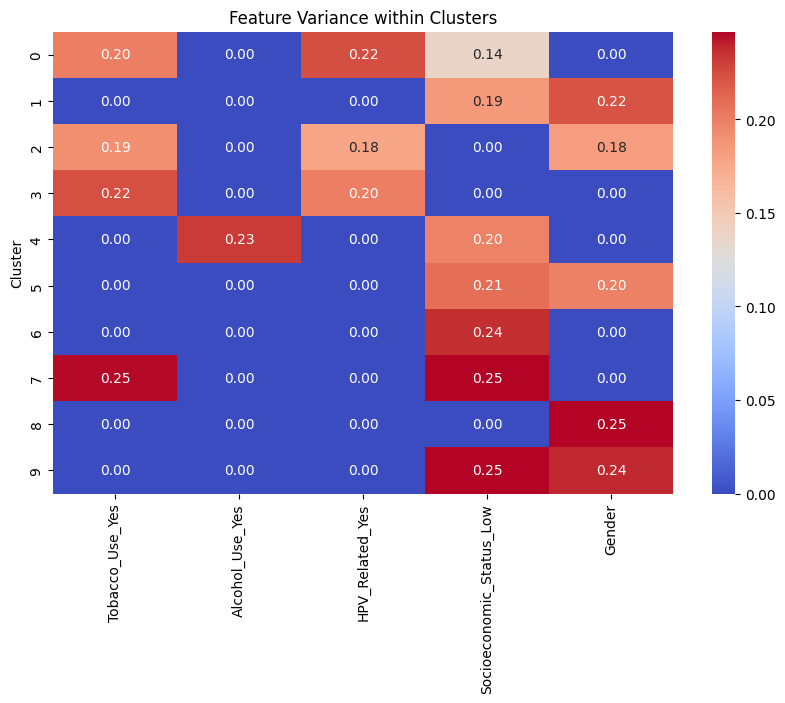

In [ ]:
# import seaborn
import seaborn as sns

# Calculate feature variance within clusters
features = ['Tobacco_Use_Yes','Alcohol_Use_Yes','HPV_Related_Yes','Socioeconomic_Status_Low','Gender']
cluster_variance = data.groupby('Cluster')[features].var()
display(cluster_variance)

# Visualize feature variance across clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_variance, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Variance within Clusters')
plt.show()

In [ ]:
# Define cluster-to-risk mapping
cluster_risk_mapping = {
    0: "High Risk",
    1: "Low Risk",
    2: "Medium Risk",
    3: "High Risk",
    4: "Medium Risk",
    5: "Medium Risk",
    6: "High Risk",
    7: "High Risk",
    8: "Low Risk",
    9: "Medium Risk"
}
# Assuming 'Cluster' column already exists in the dataset after clustering
data["Risk_Level"] = data["Cluster"].map(cluster_risk_mapping)

In [ ]:
data.head(10)

,Gender,Continent,Age_group,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes,Cluster,PCA1,PCA2,Risk_Level
0,0,4,0,True,False,False,False,True,False,True,True,False,8,-0.042281,0.146926,Low Risk
1,1,0,2,True,False,False,False,True,False,True,True,False,8,0.672187,0.509903,Low Risk
2,1,0,2,False,False,True,False,True,False,True,False,True,7,-0.007614,0.700154,High Risk
3,0,4,1,False,False,True,False,True,False,True,True,False,8,-0.042281,0.146926,Low Risk
4,0,0,0,False,False,True,False,True,False,True,True,False,8,-0.042281,0.146926,Low Risk
5,0,1,0,True,False,False,False,True,True,False,True,False,1,-0.134700,0.200323,Low Risk
6,1,2,0,False,True,False,False,True,False,True,True,False,2,0.669192,0.535189,Medium Risk
7,1,1,2,False,True,False,False,True,False,True,False,True,7,-0.010609,0.725439,High Risk
8,1,4,1,False,True,False,True,False,True,False,True,False,3,0.714090,-0.321667,High Risk
9,1,2,1,False,False,True,True,False,False,True,True,False,4,0.809504,-0.400350,Medium Risk


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64653 entries, 0 to 64652
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       64653 non-null  int64  
 1   Continent                    64653 non-null  int64  
 2   Age_group                    64653 non-null  int64  
 3   Socioeconomic_Status_High    64653 non-null  bool   
 4   Socioeconomic_Status_Low     64653 non-null  bool   
 5   Socioeconomic_Status_Middle  64653 non-null  bool   
 6   Tobacco_Use_No               64653 non-null  bool   
 7   Tobacco_Use_Yes              64653 non-null  bool   
 8   Alcohol_Use_No               64653 non-null  bool   
 9   Alcohol_Use_Yes              64653 non-null  bool   
 10  HPV_Related_No               64653 non-null  bool   
 11  HPV_Related_Yes              64653 non-null  bool   
 12  Cluster                      64653 non-null  int32  
 13  PCA1            

In [ ]:
#drop cluster, PCA1, PCA2
data = data.drop(['Cluster','PCA1','PCA2'], axis=1)

In [ ]:
data.head(10)

,Gender,Continent,Age_group,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes,Risk_Level
0,0,4,0,True,False,False,False,True,False,True,True,False,Low Risk
1,1,0,2,True,False,False,False,True,False,True,True,False,Low Risk
2,1,0,2,False,False,True,False,True,False,True,False,True,High Risk
3,0,4,1,False,False,True,False,True,False,True,True,False,Low Risk
4,0,0,0,False,False,True,False,True,False,True,True,False,Low Risk
5,0,1,0,True,False,False,False,True,True,False,True,False,Low Risk
6,1,2,0,False,True,False,False,True,False,True,True,False,Medium Risk
7,1,1,2,False,True,False,False,True,False,True,False,True,High Risk
8,1,4,1,False,True,False,True,False,True,False,True,False,High Risk
9,1,2,1,False,False,True,True,False,False,True,True,False,Medium Risk


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the correct directory and filename
folder_path = "/content/drive/MyDrive/DSGP/New"
file_name = "new_target_dataset.csv"
full_path = os.path.join(folder_path, file_name)

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save the dataset
data.to_csv(full_path, index=False)

print(f"Preprocessed dataset saved to: {full_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocessed dataset saved to: /content/drive/MyDrive/DSGP/New/new_target_dataset.csv
